# Loading Libraries

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

# Loading the Dataset

In [24]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

print("Original number of null values\n", dataset.isnull().sum())
dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])
print("Number of null values after fixing\n", dataset.isnull().sum())


X = dataset.drop('fire', axis=1)
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
# Y = dataset['fire']

print(X.head())
# print(Y.head())

X = X.to_numpy() 


# X_train, X_test, Y_train, Y_test = train_test_split(
#     X.to_numpy(), Y.to_numpy(),
#     test_size=0.2,      # 20% test
#     random_state=42,    # for reproducibility
#     shuffle=True        # default True
# )

Original number of null values
 fire                            0
log_precip_s1               44155
log_precip_s2               44155
log_precip_s3               44155
log_precip_s4               44155
tmax_s1                     44155
tmax_s2                     44155
tmax_s3                     44155
tmax_s4                     44155
amplitude_thermique_s1      44155
amplitude_thermique_s2      44155
amplitude_thermique_s3      44155
amplitude_thermique_s4      44155
GRIDCODE                        0
log_area_sqm                    0
lcc_code_encoded                0
distance_to_centroid_deg        0
distance_to_centroid_m          0
elevation                     928
COARSE                          0
SAND                            0
SILT                            0
CLAY                            0
TEXTURE_USDA                    0
TEXTURE_SOTER                   0
BULK                            0
REF_BULK                        0
ORG_CARBON                      0
PH_WATER        

# Testing Functions

In [16]:
def plot_dbscan_results(X, labels):
    # Plot results
    unique_labels = set(labels)

    plt.figure(figsize=(8, 6))

    for label in unique_labels:
        if label == -1:
            # noise = black
            plt.scatter(X[labels == label, 0], X[labels == label, 1],
                        s=25, c="black", marker="x", label="Noise")
        else:
            plt.scatter(X[labels == label, 0], X[labels == label, 1],
                        s=25, label=f"Cluster {label}")

    plt.title("DBSCAN Clustering Results")
    plt.legend()
    plt.grid(True)
    plt.show()

# SKlearn Implementation

In [21]:
dbscan = DBSCAN(eps=4, min_samples=5)

# SKlearn Testing

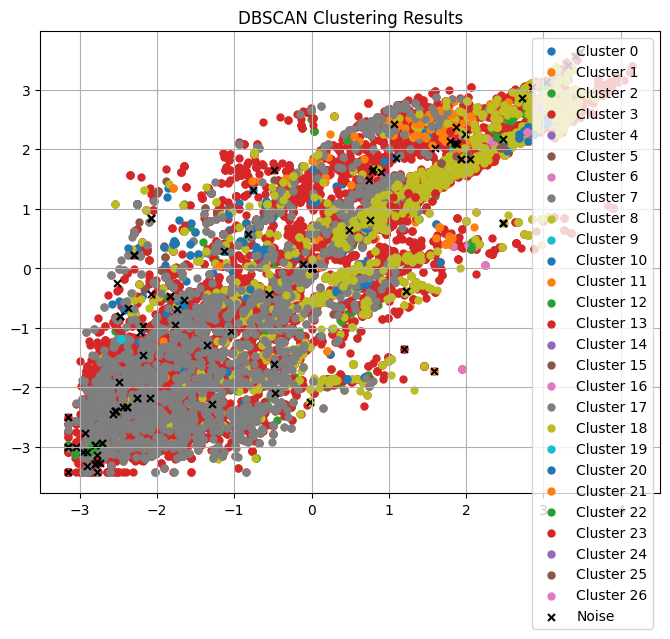

In [22]:
dbscan.fit(X)
labels = dbscan.labels_

plot_dbscan_results(X, labels)

# Scratch Implementation

In [12]:
import numpy as np

class DBScan:
    def __init__(self, min_samples, distance_threshold):
        self.min_samples = min_samples
        self.distance_threshold = distance_threshold

    def fit(self, X):
        n_samples = X.shape[0]
        labels = -1 * np.ones(n_samples)   # -1 = noise
        visited = np.zeros(n_samples, dtype=bool)

        cluster_id = 0

        for i in range(n_samples):
            if visited[i]:
                continue

            visited[i] = True
            neighbors = self._region_query(X, i)

            if len(neighbors) < self.min_samples:
                labels[i] = -1  # noise
            else:
                self._expand_cluster(X, labels, visited, i, neighbors, cluster_id)
                cluster_id += 1

        self.labels_ = labels
        return self

    def _region_query(self, X, point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= self.distance_threshold)[0].tolist()

    def _expand_cluster(self, X, labels, visited, point_idx, neighbors, cluster_id):
        labels[point_idx] = cluster_id

        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]

            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                neighbor_neighbors = self._region_query(X, neighbor_idx)

                if len(neighbor_neighbors) >= self.min_samples:
                    neighbors.extend(neighbor_neighbors)

            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

            i += 1


# Scratch Testing

In [13]:
np.random.seed(42)

# cluster1 = np.random.randn(100, 2) * 0.3 + np.array([0, 0])
# cluster2 = np.random.randn(100, 2) * 0.3 + np.array([3, 3])
# cluster3 = np.random.randn(100, 2) * 0.3 + np.array([0, 4])

# noise = np.random.uniform(-1, 5, (30, 2))

# X = np.vstack([cluster1, cluster2, cluster3, noise])

# Run your DBSCAN
model = DBScan(min_samples=5, distance_threshold=0.5)
model.fit(X)
labels = model.labels_




KeyboardInterrupt: 